##UNIEURO PROJECT by Annalaura Granata, Daniele Lupico, Gabriele Rizzo


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#PACKAGES


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import LabelEncoder
import missingno as msno
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
import optuna
from google.colab import files

ModuleNotFoundError: No module named 'optuna'

#DATASET


In [ ]:
#TRAINING
an_prod = pd.read_csv("/content/drive/MyDrive/UNIEURO/training/anagrafica_prodotti_training.csv")
annomese = pd.read_csv("/content/drive/MyDrive/UNIEURO/training/risultati_annomese_training.csv")
info_bs= pd.read_csv("/content/drive/MyDrive/UNIEURO/training/informazioni_business_training.csv")

In [ ]:
#TEST
an_prod_test = pd.read_csv('/content/drive/MyDrive/UNIEURO/test/anagrafica_prodotti_test.csv')
info_bs_test = pd.read_csv('/content/drive/MyDrive/UNIEURO/test/informazioni_business_test.csv')
lista_test = pd.read_csv('/content/drive/MyDrive/UNIEURO/test/lista_prodotti_test.csv')

#EDA

##ANAGRAFICA PRODOTTI DATASET


In [ ]:
an_prod.isna().sum() #method for counting nan values non effective

In [ ]:
# PRIMA_VENDITA only year and month
an_prod['PRIMA_VENDITA'] = pd.to_datetime(an_prod['PRIMA_VENDITA'])
an_prod['PRIMA_VENDITA'] = an_prod['PRIMA_VENDITA'].dt.strftime('%Y-%m')
#MISSING VALUE
columns_to_check = an_prod.columns[:-1]
#REPLACE WHASINGMACHINES FREESTANDING
an_prod['PRODUCT_GROUP'] = an_prod['PRODUCT_GROUP'].replace('WASHINGMACHINES FREESTANDING', 'WASHINGMACHINES')
#NAN
for column in columns_to_check:
    nd_count = (an_prod[column].astype(str).str.strip().str.upper() == 'ND').sum()
    print(f"Number of 'ND' values in {column} column: {nd_count}")

#ONLY THE IMPORTANT VARIABLES
an_prod = an_prod[['ITEM_ID', 'PRODUCT_GROUP','ART_COD']]

##ANNOMESE


In [ ]:
annomese= annomese.copy()
columns_to_check = annomese.columns
for column in columns_to_check:
    nd_count = (annomese[column].astype(str).str.strip().str.upper() == 'ND').sum()
    print(f"Number of 'ND' values in {column} column: {nd_count}")

In [ ]:
print(annomese['ART_COD'].nunique())
print(an_prod['ART_COD'].nunique())

##FIRST MERGE

In [ ]:
merged_df = pd.merge(annomese,an_prod, on="ART_COD", how="outer")


In [ ]:
merged_df = merged_df.drop_duplicates(subset=['ART_COD', 'ANNOMESE'])

In [ ]:
merged_df

In [ ]:
missing_qta_rows = merged_df[merged_df['QTA'].isna()]
print(missing_qta_rows)
print(merged_df.isna().sum())

##INFO BUSINESS

In [ ]:
info_bs= info_bs.copy()
info_bs= info_bs.drop(columns=['DISP_PZ','OUT_OF_STOCK']) #for a possible economic interpretation
info_bs['PREZZO_LISTINO_MEDIO'] = info_bs['PREZZO_LISTINO_MEDIO'].round(2)

In [ ]:
missing_values = info_bs[['GRIGLIA_DAYS', 'STATO_GRIGLIA', 'PREZZO_LISTINO_MEDIO']].isna().sum()
print(missing_values)

missing_griglia_rows = info_bs[info_bs['GRIGLIA_DAYS'].isna()]
print(missing_griglia_rows)

##SECOND MERGE


In [ ]:
df = pd.merge(
    merged_df,
    info_bs,
    on=['ART_COD', 'ITEM_ID', 'ANNOMESE'],
    how='outer'
)

In [ ]:
df = df.drop_duplicates(subset=['ART_COD', 'ANNOMESE', 'ITEM_ID'])

In [ ]:
columns_to_check = df.columns

for column in columns_to_check:
    missing_count = df[column].isna().sum()
    nd_count = (df[column].astype(str).str.strip().str.upper() == 'ND').sum()

    print(f"Column: {column}")
    print(f"  → Missing (NaN) values: {missing_count}")
    print(f"  → 'ND' values: {nd_count}\n")

In [ ]:
subset_all_nan = df[df[[ 'QTA', 'FATTURATO', 'NVOLANTINI', 'PREZZO_LISTINO_MEDIO', 'GRIGLIA_DAYS', 'STATO_GRIGLIA','NVOLANTINI', 'PREZZO_MEDIO']].isna().all(axis=1)]
subset_all_nan

In [ ]:
# CHECK NAN VALUES
df = df[~df[[
    'QTA', 'FATTURATO', 'NVOLANTINI', 'PREZZO_LISTINO_MEDIO',
    'GRIGLIA_DAYS', 'STATO_GRIGLIA','NVOLANTINI', 'PREZZO_MEDIO'
]].isna().all(axis=1)]

In [ ]:
#dummy column for all nan value
df['TUTTO_NAN'] = df[['NVOLANTINI', 'PREZZO_LISTINO_MEDIO', 'GRIGLIA_DAYS', 'STATO_GRIGLIA', 'PREZZO_MEDIO']].isna().all(axis=1).astype(int)

In [ ]:
print(f"df.shape: {df.shape}, nan value in df: {df.isna().sum()}, art_cod unici: {df['ART_COD'].nunique()}")

##NAN PLOT


In [ ]:
msno.matrix(df, figsize=(10,6), color=(0.25, 0.45, 0.6))
plt.title('Visualizzazione dei valori mancanti con Missingno')
plt.tight_layout()
plt.show()

In [ ]:
df[['PREZZO_LISTINO_MEDIO', 'GRIGLIA_DAYS']].describe().T

##IMPUTATION --> prezzo_listino_medio with median , stato_griglia with mode

In [ ]:
df= df.copy()
# 1. Imputation PREZZO_LISTINO_MEDIO
df['PREZZO_LISTINO_MEDIO'] = df.groupby('ITEM_ID')['PREZZO_LISTINO_MEDIO'].transform(
    lambda x: x.fillna(x.median()))


# 2. Imputation STATO_GRIGLIA with mode of ITEM_ID
def mode_or_nd(series):
    mode = series.mode()
    if len(mode) == 0:
        return "ND"  # fallback if column == NAN
    return mode[0]

#Apply the function: the NaN become the mode of the ITEM_ID group, or “ND”
df['STATO_GRIGLIA'] = df.groupby('ITEM_ID')['STATO_GRIGLIA'].transform(
    lambda x: x.fillna(mode_or_nd(x))
)

# 3.Imputation GRIGLIA_DAYS

# median for (ITEM_ID, STATO_GRIGLIA)
df['GRIGLIA_DAYS'] = df.groupby(['ITEM_ID', 'STATO_GRIGLIA'])['GRIGLIA_DAYS'].transform(
    lambda x: x.fillna(x.median())
)
print(f"df.shape: {df.shape}, nan value in df: {df.isna().sum()}, art_cod unici: {df['ART_COD'].nunique()}")

## SPLIT BY PRODUCT GROUP

In [ ]:
wm_df = df[df['PRODUCT_GROUP'] == 'WASHINGMACHINES']
sp_df = df[df['PRODUCT_GROUP'] == 'SMARTPHONES']
vc_df = df[df['PRODUCT_GROUP'] == 'ASPIRAPOLVERE']


print(f"Washing Machines dataset shape: {wm_df.shape}")
print(f"Smartphones dataset shape: {sp_df.shape}")
print(f"Aspirapolvere dataset shape: {vc_df.shape}")

## LINE PLOT BY QUARTER

In [ ]:
# function to format 5000 in 5k
def format_thousands(x, pos):
    return f'{int(x/1000)}k'

# QTA aggregation by quarter
def aggrega_trimestri(df, nome_gruppo):
    df = df.copy()
    df['ANNOMESE'] = pd.to_datetime(df['ANNOMESE'], format='%Y-%m')
    df['TRIMESTRE'] = df['ANNOMESE'].dt.to_period('Q')
    df_grouped = df.groupby('TRIMESTRE')['QTA'].sum().reset_index()
    df_grouped['GROUP'] = nome_gruppo
    return df_grouped

# Aggregation
wm_qta = aggrega_trimestri(wm_df, 'Washing Machines')
sp_qta = aggrega_trimestri(sp_df, 'Smartphones')
vc_qta = aggrega_trimestri(vc_df, 'Aspirapolvere')

df_qta_tutti = pd.concat([wm_qta, sp_qta, vc_qta])
df_qta_tutti = df_qta_tutti.sort_values('TRIMESTRE')
df_qta_tutti['TRIMESTRE_STR'] = df_qta_tutti['TRIMESTRE'].astype(str).str.replace('Q', '-Q')

colori = {
    'Washing Machines': 'steelblue',
    'Smartphones': 'darkorange',
    'Aspirapolvere': 'green'
}

# Plot
plt.figure(figsize=(12, 6))

for group, data in df_qta_tutti.groupby('GROUP'):
    plt.plot(data['TRIMESTRE_STR'], data['QTA'], label=group, marker='o', color=colori[group])

plt.title('Quarterly Sales (QTA) by Category')
plt.xlabel('Quarter')
plt.ylabel('Units Sold (QTA)')
plt.xticks(rotation=45)

plt.ylim(bottom=0)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

 INSIGHT: every Q3-Q4 we sell a lot of products, much larger smartphone market than the other two categories, although it has major drawdowns every time we pass q4


#BENCHMARK MODELS

##Global Forecast

In [ ]:
# Step 1: Aggregate all categories globally
df_global = df_qta_tutti.groupby('TRIMESTRE')['QTA'].sum().reset_index()
df_global['ANNO'] = df_global['TRIMESTRE'].dt.year
df_global['NUM_TRIMESTRE'] = df_global['TRIMESTRE'].dt.quarter
df_global['TRIMESTRE_STR'] = df_global['TRIMESTRE'].astype(str)

# Step 2: Split train/test
train = df_global[df_global['ANNO'] < 2023].copy()
test = df_global[df_global['ANNO'] == 2023].copy()

# Step 3: Naive (meean by quarter)
media_naive = train.groupby('NUM_TRIMESTRE')['QTA'].mean().reset_index()
media_naive.rename(columns={'QTA': 'QTA_PRED_NAIVE'}, inplace=True)

test_pred = pd.merge(test, media_naive, on='NUM_TRIMESTRE', how='left')

# Step 4: Weighted moving average
pesi = {
    2017: 0.4,
    2018: 0.6,
    2019: 0.8,
    2020: 0.2,   # Higly penalized by COVID
    2021: 1.2,
    2022: 1.6    #Most relevants
}

train['PESO'] = train['ANNO'].map(pesi)

media_ponderata = []
for trimestre in range(1, 5):
    subset = train[train['NUM_TRIMESTRE'] == trimestre]
    if not subset.empty:
        media_pond = np.average(subset['QTA'], weights=subset['PESO'])
        media_ponderata.append({'NUM_TRIMESTRE': trimestre, 'QTA_PRED_POND': media_pond})
media_ponderata_df = pd.DataFrame(media_ponderata)

test_pred = pd.merge(test_pred, media_ponderata_df, on='NUM_TRIMESTRE', how='left')

#####
# 1. exclude 2020
train_filtered = train[~train['ANNO'].isin([2020])]

# 2.
ts_train = train_filtered.sort_values('TRIMESTRE').set_index('TRIMESTRE')['QTA']

# 3.Holt winters
model_hw = ExponentialSmoothing(
    ts_train,
    trend='add',
    seasonal='add',
    seasonal_periods=4  # quarters
)
fit_hw = model_hw.fit(optimized=True)

# 4. Forecast 2023
forecast_hw = fit_hw.forecast(4)
forecast_hw.index = pd.PeriodIndex(['2023Q1', '2023Q2', '2023Q3', '2023Q4'], freq='Q')

# 5. Merge with test set
hw_df = pd.DataFrame({
    'TRIMESTRE_STR': forecast_hw.index.astype(str),
    'QTA_PRED_HW': forecast_hw.values
})
test_pred = pd.merge(test_pred, hw_df, on='TRIMESTRE_STR', how='left')
test_pred.rename(columns={'QTA': 'QTA_TRUE'}, inplace=True)


# Step 6: Evaluate
def mape(y_true, y_pred):
    return (np.abs(y_true - y_pred) / y_true).mean() * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae_naive = mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_NAIVE'])
mae_pond = mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_POND'])
mae_hw = mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_HW'])

mape_naive = mape(test_pred['QTA_TRUE'], test_pred['QTA_PRED_NAIVE'])
mape_pond = mape(test_pred['QTA_TRUE'], test_pred['QTA_PRED_POND'])
mape_hw = mape(test_pred['QTA_TRUE'], test_pred['QTA_PRED_HW'])

rmse_naive = rmse(test_pred['QTA_TRUE'], test_pred['QTA_PRED_NAIVE'])
rmse_pond = rmse(test_pred['QTA_TRUE'], test_pred['QTA_PRED_POND'])
rmse_hw = rmse(test_pred['QTA_TRUE'], test_pred['QTA_PRED_HW'])

print("\n GLOBAL FORECAST — RISULTATI 2023")
print("------------------------------------------------")
print(f"MAE    | Naive: {mae_naive:.2f} | Ponderata: {mae_pond:.2f} | HW: {mae_hw:.2f}")
print(f"MAPE   | Naive: {mape_naive:.2f}% | Ponderata: {mape_pond:.2f}% | HW: {mape_hw:.2f}%")
print(f"RMSE   | Naive: {rmse_naive:.2f} | Ponderata: {rmse_pond:.2f} | HW: {rmse_hw:.2f}")
print("------------------------------------------------")

# Step 7: Retrain HW on full data for 2024 forecast
full_series = df_global.sort_values('TRIMESTRE').set_index('TRIMESTRE')['QTA']
model_full = ExponentialSmoothing(
    full_series,
    trend='add',
    seasonal='add',
    seasonal_periods=4
)
fit_full = model_full.fit(optimized=True)
forecast_2024 = fit_full.forecast(4)
forecast_2024.index = pd.PeriodIndex(['2024Q1', '2024Q2', '2024Q3', '2024Q4'], freq='Q')

print("\n FORECAST 2024 — Totale Global")
print(forecast_2024)

In [ ]:
##PLOT
def format_thousands(x, pos):
    return f'{int(x/1000)}k'

plt.figure(figsize=(12, 6))

plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_TRUE'],
         marker='o', linewidth=2, label='Reale', color='blue')
plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_PRED_NAIVE'],
         marker='x', linestyle='--', label='Naive', color='orange')
plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_PRED_POND'],
         marker='^', linestyle='--', label='Ponderata', color='green')
plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_PRED_HW'],
         marker='s', linestyle='--', label='Holt-Winters', color='red')

plt.title('Global Forecast Comparison – 2023', fontsize=14)
plt.xlabel('Quarters')
plt.ylabel('sold QTA')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## METRICS

In [ ]:
metrics_dict = {
    'MAE': {
        'Naive': mae_naive,
        'Weighted': mae_pond,
        'Holt-Winters': mae_hw
    },
    'MAPE (%)': {
        'Naive': mape_naive,
        'Weighted': mape_pond,
        'Holt-Winters': mape_hw
    },
    'RMSE': {
        'Naive': rmse_naive,
        'Weighted': rmse_pond,
        'Holt-Winters': rmse_hw
    }
}

metrics_df = pd.DataFrame(metrics_dict).T
highlighted = metrics_df.style.highlight_min(axis=1, color='green').format("{:,.2f}")


highlighted

## Forecast by product group

In [ ]:
def forecast_per_category(df, nome_gruppo):
    df = df.copy()
    df['ANNOMESE'] = pd.to_datetime(df['ANNOMESE'], format='%Y-%m')
    df['TRIMESTRE'] = df['ANNOMESE'].dt.to_period('Q')
    df_trim = df.groupby('TRIMESTRE')['QTA'].sum().reset_index()
    df_trim['ANNO'] = df_trim['TRIMESTRE'].dt.year
    df_trim['NUM_TRIMESTRE'] = df_trim['TRIMESTRE'].dt.quarter

    # Split train/test
    train_trim = df_trim[df_trim['ANNO'] < 2023].copy()
    test_trim = df_trim[df_trim['ANNO'] == 2023].copy()
    test_trim['TRIMESTRE_STR'] = test_trim['TRIMESTRE'].astype(str)

    # Naive quarterly mean
    naive_mean = train_trim.groupby('NUM_TRIMESTRE')['QTA'].mean().reset_index()
    naive_mean.rename(columns={'QTA': 'QTA_PRED_NAIVE'}, inplace=True)
    test_pred = pd.merge(test_trim, naive_mean, on='NUM_TRIMESTRE', how='left')

    # Weighted moving average
    pesi = {2017: 0.5, 2018: 0.7, 2019: 0.8, 2020: 0.9, 2021: 1.2, 2022: 1.5}
    train_trim['PESO'] = train_trim['ANNO'].map(pesi)
    media_ponderata = []
    for trimestre in range(1, 5):
        subset = train_trim[train_trim['NUM_TRIMESTRE'] == trimestre]
        if not subset.empty:
            media_pond = np.average(subset['QTA'], weights=subset['PESO'])
            media_ponderata.append({'NUM_TRIMESTRE': trimestre, 'QTA_PRED_POND': media_pond})
    media_ponderata = pd.DataFrame(media_ponderata)
    test_pred = pd.merge(test_pred, media_ponderata, on='NUM_TRIMESTRE', how='left')

    # Holt-Winters forecast
    ts_train = train_trim.sort_values('TRIMESTRE').set_index('TRIMESTRE')['QTA']
    try:
        model_hw = ExponentialSmoothing(ts_train, trend='add', seasonal='mul', seasonal_periods=4, use_boxcox=True)
        fit_hw = model_hw.fit(remove_bias=True)
        forecast_hw = fit_hw.forecast(4)
        forecast_hw.index = pd.PeriodIndex(['2023Q1', '2023Q2', '2023Q3', '2023Q4'], freq='Q')
        hw_predictions = pd.DataFrame({'TRIMESTRE': forecast_hw.index, 'QTA_PRED_HW': forecast_hw.values})
        hw_predictions['TRIMESTRE_STR'] = hw_predictions['TRIMESTRE'].astype(str)
        test_pred = pd.merge(test_pred, hw_predictions[['TRIMESTRE_STR', 'QTA_PRED_HW']], on='TRIMESTRE_STR', how='left')
    except:
        test_pred['QTA_PRED_HW'] = np.nan

    # Evaluation
    test_pred['QTA_TRUE'] = test_pred['QTA']
    mae_naive = mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_NAIVE'])
    mae_pond = mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_POND'])
    mae_hw = mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_HW'])

    mape_naive = np.mean(np.abs((test_pred['QTA_TRUE'] - test_pred['QTA_PRED_NAIVE']) / test_pred['QTA_TRUE'])) * 100
    mape_pond = np.mean(np.abs((test_pred['QTA_TRUE'] - test_pred['QTA_PRED_POND']) / test_pred['QTA_TRUE'])) * 100
    mape_hw = np.mean(np.abs((test_pred['QTA_TRUE'] - test_pred['QTA_PRED_HW']) / test_pred['QTA_TRUE'])) * 100

    rmse_naive = np.sqrt(mean_squared_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_NAIVE']))
    rmse_pond = np.sqrt(mean_squared_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_POND']))
    rmse_hw = np.sqrt(mean_squared_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_HW']))

    print(f"\n {nome_gruppo.upper()} — RESULTS 2023")
    print("-" * 50)
    print(f"MAE   | Naive: {mae_naive:.2f} | Weighted: {mae_pond:.2f} | HW: {mae_hw:.2f}")
    print(f"MAPE  | Naive: {mape_naive:.2f}% |Weighted: {mape_pond:.2f}% | HW: {mape_hw:.2f}%")
    print(f"RMSE  | Naive: {rmse_naive:.2f} | Weighted: {rmse_pond:.2f} | HW: {rmse_hw:.2f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_TRUE'], marker='o', label='Reali')
    plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_PRED_NAIVE'], marker='x', linestyle='--', label='Naive')
    plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_PRED_POND'], marker='^', linestyle='--', label='Weighted')
    plt.plot(test_pred['TRIMESTRE_STR'], test_pred['QTA_PRED_HW'], marker='s', linestyle='--', label='Holt-Winters')
    plt.title(f'Forecast vs Actual - {nome_gruppo}')
    plt.xlabel('Quarter')
    plt.ylabel('QTA')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Forecast 2024
    full_trim = pd.concat([train_trim, test_trim])
    ts_full = full_trim.sort_values('TRIMESTRE').set_index('TRIMESTRE')['QTA']
    forecast_2024 = None
    try:
        model_full = ExponentialSmoothing(ts_full, trend='add', seasonal='mul', seasonal_periods=4, use_boxcox=True)
        fit_full = model_full.fit(remove_bias=True)
        forecast_2024 = fit_full.forecast(4)
        forecast_2024.index = pd.PeriodIndex(['2024Q1', '2024Q2', '2024Q3', '2024Q4'], freq='Q')
        print(f"\n FORECAST 2024 - {nome_gruppo}")
        print(forecast_2024)
    except:
        print(f" Holt-Winters forecast failed for {nome_gruppo}")

    return forecast_2024, test_pred


In [ ]:
forecast_per_category(sp_df, "Smartphones")
forecast_per_category(wm_df, "Washing Machines")
forecast_per_category(vc_df, "Aspirapolvere")


## Forecast by art_cod
   

In [ ]:
df_art = df.copy()

# Filter for ART_COD with month >= 12
art_months = df_art.groupby('ART_COD')['ANNOMESE'].nunique()
art_cod_validi = art_months[art_months >= 12].index.tolist()

risultati_art = []

for art_cod in art_cod_validi:
    df_item = df_art[df_art['ART_COD'] == art_cod].copy()
    df_item['ANNOMESE'] = pd.to_datetime(df_item['ANNOMESE'], errors='coerce')
    df_item = df_item.groupby('ANNOMESE')['QTA'].sum().reset_index()
    df_item['TRIMESTRE'] = df_item['ANNOMESE'].dt.to_period('Q')

    df_trim = df_item.groupby('TRIMESTRE')['QTA'].sum().reset_index()
    df_trim['ANNO'] = df_trim['TRIMESTRE'].dt.year
    df_trim['NUM_TRIMESTRE'] = df_trim['TRIMESTRE'].dt.quarter
    df_trim['TRIMESTRE_STR'] = df_trim['TRIMESTRE'].astype(str)

    train = df_trim[df_trim['ANNO'] < 2023].copy()
    test = df_trim[df_trim['ANNO'] == 2023].copy()

    if len(test) < 4 or len(train) < 4:
        continue

    naive_mean = train.groupby('NUM_TRIMESTRE')['QTA'].mean().reset_index()
    naive_mean.rename(columns={'QTA': 'QTA_PRED_NAIVE'}, inplace=True)
    test_pred = pd.merge(test, naive_mean, on='NUM_TRIMESTRE', how='left')

    pesi = {2017: 0.5, 2018: 0.7, 2019: 0.8, 2020: 0.9, 2021: 1.2, 2022: 1.5}  #weights
    train['PESO'] = train['ANNO'].map(pesi)
    media_ponderata = []
    for trimestre in range(1, 5):
        subset = train[train['NUM_TRIMESTRE'] == trimestre]
        if not subset.empty:
            media_pond = np.average(subset['QTA'], weights=subset['PESO'])
            media_ponderata.append({'NUM_TRIMESTRE': trimestre, 'QTA_PRED_POND': media_pond})
    media_ponderata_df = pd.DataFrame(media_ponderata)
    test_pred = pd.merge(test_pred, media_ponderata_df, on='NUM_TRIMESTRE', how='left')

    forecast_2024 = np.nan
    try:
        ts_train = train.sort_values('TRIMESTRE').set_index('TRIMESTRE')['QTA']
        model_hw = ExponentialSmoothing(ts_train, trend='add', seasonal='add', seasonal_periods=4)
        fit_hw = model_hw.fit(optimized=True)
        forecast_hw = fit_hw.forecast(4)
        forecast_hw.index = pd.PeriodIndex(['2023Q1', '2023Q2', '2023Q3', '2023Q4'], freq='Q')
        hw_df = pd.DataFrame({
            'TRIMESTRE_STR': forecast_hw.index.astype(str),
            'QTA_PRED_HW': forecast_hw.values
        })
        test_pred = pd.merge(test_pred, hw_df, on='TRIMESTRE_STR', how='left')

        # Forecast 2024
        full_series = df_trim[df_trim['ANNO'] <= 2023].sort_values('TRIMESTRE').set_index('TRIMESTRE')['QTA']
        model_full = ExponentialSmoothing(full_series, trend='add', seasonal='add', seasonal_periods=4)
        fit_full = model_full.fit(optimized=True)
        forecast_2024 = fit_full.forecast(4).sum()
    except:
        test_pred['QTA_PRED_HW'] = np.nan

    test_pred['QTA_TRUE'] = test_pred['QTA']

    try:
        risultati_art.append({
            'ART_COD': art_cod,
            'MAE_NAIVE': mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_NAIVE']),
            'MAPE_NAIVE': (abs(test_pred['QTA_PRED_NAIVE'] - test_pred['QTA_TRUE']) / test_pred['QTA_TRUE']).mean() * 100,
            'RMSE_NAIVE': np.sqrt(mean_squared_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_NAIVE'])),

            'MAE_POND': mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_POND']),
            'MAPE_POND': (abs(test_pred['QTA_PRED_POND'] - test_pred['QTA_TRUE']) / test_pred['QTA_TRUE']).mean() * 100,
            'RMSE_POND': np.sqrt(mean_squared_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_POND'])),

            'MAE_HW': mean_absolute_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_HW']),
            'MAPE_HW': (abs(test_pred['QTA_PRED_HW'] - test_pred['QTA_TRUE']) / test_pred['QTA_TRUE']).mean() * 100,
            'RMSE_HW': np.sqrt(mean_squared_error(test_pred['QTA_TRUE'], test_pred['QTA_PRED_HW'])),

            'QTA_TRUE_2023': test_pred['QTA_TRUE'].mean(),
            'QTA_NAIVE_2023': test_pred['QTA_PRED_NAIVE'].mean(),
            'QTA_POND_2023': test_pred['QTA_PRED_POND'].mean(),
            'QTA_HW_2023': test_pred['QTA_PRED_HW'].mean(),

            'FORECAST_2024_SUM_HW': forecast_2024
        })
    except:
        continue

#df
df_risultati_art = pd.DataFrame(risultati_art)

#best model
def best_model_mae(row):
    maes = {
        'Naive': row['MAE_NAIVE'],
        'Ponderata': row['MAE_POND'],
        'Holt-Winters': row['MAE_HW']
    }
    return min(maes, key=maes.get)

df_risultati_art['BEST_MODEL'] = df_risultati_art.apply(best_model_mae, axis=1)

In [ ]:
# RMSE Holt-Winters
rmse_generale_hw = np.sqrt(np.mean(df_risultati_art['RMSE_HW'] ** 2))
print(f" RMSE Holt-Winters: {rmse_generale_hw:.2f}")

# FEATURE ENGINEERING

In [ ]:
# --- Label Encoding of PRODUCT_GROUP ---
le_group = LabelEncoder()
df['PRODUCT_GROUP_ENC'] = le_group.fit_transform(df['PRODUCT_GROUP'])

# --- Label Encoding of STATO_GRIGLIA ---
le_griglia = LabelEncoder()
df['STATO_GRIGLIA_ENC'] = le_griglia.fit_transform(df['STATO_GRIGLIA'].astype(str))

# Product Group encoding
for i, label in enumerate(le_group.classes_):
    print(f"{label} → {i}")

# Stato Griglia encoding
for i, label in enumerate(le_griglia.classes_):
    print(f"{label} → {i}")

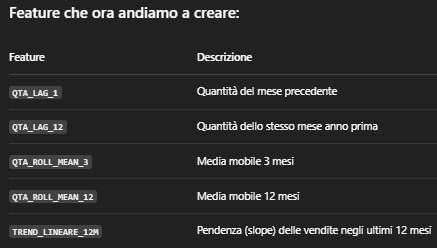

In [ ]:
###    CREATION     ####
import numpy as np
from sklearn.linear_model import LinearRegression


df = df.sort_values(['ART_COD', 'ANNOMESE'])
df['ANNOMESE'] = pd.to_datetime(df['ANNOMESE'], format='%Y-%m')
df['YEAR'] = df['ANNOMESE'].dt.year
df['MONTH'] = df['ANNOMESE'].dt.month

# LAG di QTA
df['QTA_LAG_1'] = df.groupby('ART_COD')['QTA'].shift(1)
df['QTA_LAG_12'] = df.groupby('ART_COD')['QTA'].shift(12) # for the validation model

#FATTURATO LAG
df['FATTURATO_LAG_1'] = df.groupby('ART_COD')['FATTURATO'].shift(1)
df['FATTURATO_LAG_12'] = df.groupby('ART_COD')['FATTURATO'].shift(12) #for the validation model

# MOVING AVERAGE QTA
df['QTA_ROLL_MEAN_3'] = df.groupby('ART_COD')['QTA'].transform(lambda x: x.shift(1).rolling(window=3).mean())
df['QTA_ROLL_MEAN_12'] = df.groupby('ART_COD')['QTA'].transform(lambda x: x.shift(1).rolling(window=12).mean())

# LINEAR TREND
def calculate_slope(x):
    if x.isnull().sum() > 0:
        return np.nan
    y = x.values.reshape(-1, 1)
    X = np.arange(len(x)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0][0]  # slope

df['TREND_LINEARE_12M'] = (
    df.groupby('ART_COD')['QTA']
    .transform(lambda x: x.shift(1).rolling(window=12).apply(calculate_slope, raw=False))
)

In [ ]:
df[['ART_COD', 'ANNOMESE', 'QTA', 'QTA_LAG_1', 'QTA_LAG_12',
    'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12', 'TREND_LINEARE_12M', 'FATTURATO_LAG_12']].head(10)

df[['QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3',
   'QTA_ROLL_MEAN_12', 'TREND_LINEARE_12M', 'FATTURATO_LAG_12']].isnull().mean().round(3)

forecasting well the peak selling months is important because during those months there are out of stock and we might lose potential customers, that is why I also weight the months, while in Q1-Q2 we might have problems like over stock but it can be remedied by selling them during q3-q4 at black friday for example.

In [ ]:
 ###   WEIGHT CREATION ###
df = df.copy()

df['MESE_IMPORTANTE'] = df['MONTH'].apply(lambda x: 1 if x >= 8 else 0)

# ANNUAL WEIGHTS
peso_anno_dict = {
    2023: 1.0,
    2022: 0.9,
    2021: 0.8,
    2020: 0.3,  #COVID
    2019: 0.7,
    2018: 0.6,
    2017: 0.5
}

df['PESO_ANNO'] = df['YEAR'].map(peso_anno_dict)


# MONTHLY WEIGHTS

peso_mese_dict = {
    1: 0.4, 2: 0.4, 3: 0.5,
    4: 0.5, 5: 0.6, 6: 0.7,
    7: 0.8, 8: 0.9, 9: 0.95,
    10: 1.0, 11: 1.0, 12: 1.0
}

df['PESO_MESE'] = df['MONTH'].map(peso_mese_dict)


#FINAL WIEGHTS
df['PESO_FINALE'] = df['PESO_ANNO'] * df['PESO_MESE']
df['PESO_FINALE'].fillna(0.5, inplace=True)  # neutral value

In [ ]:
df[['ANNOMESE', 'MONTH', 'YEAR', 'MESE_IMPORTANTE',
    'PESO_ANNO', 'PESO_MESE', 'PESO_FINALE']].sample(10)

In [ ]:
##   CREATION ##
df = df.sort_values(['ART_COD', 'ANNOMESE'])

# calculates the earliest available date for each product
prima_vendita = df.groupby('ART_COD')['ANNOMESE'].transform('min')

# months since launch
df['MONTHS_SINCE_LAUNCH'] = ((df['ANNOMESE'].dt.year - prima_vendita.dt.year) * 12 +
                             (df['ANNOMESE'].dt.month - prima_vendita.dt.month))
df[['ART_COD', 'ANNOMESE', 'MONTHS_SINCE_LAUNCH']].sample(10)

I create one more variable, it is called GROWTH Year over Year (YOY).
Basically I want the percentage change in sales compared to the same year in the previous year (December 2020-December 2021-December 2022 etc..)
This is useful for understanding whether products are growing in a monthly trend or not..
 What you need it for in forecasting:
- Reports accelerations or slowdowns over time
(e.g., if a product grows +40% every December → the model learns this)

- Makes true seasonal dynamics visible, not just absolute value

- Helps differentiate “stable” products from changing ones
(e.g., a new product growing strongly ≠ one that always sells the same)

In [ ]:
###   GROWTH YOY    ###

# Growth YoY with protection for division over 0
df['GROWTH_YOY'] = (df['QTA'] - df['QTA_LAG_12']) / df['QTA_LAG_12']
df['GROWTH_YOY'].replace([np.inf, -np.inf], np.nan, inplace=True)

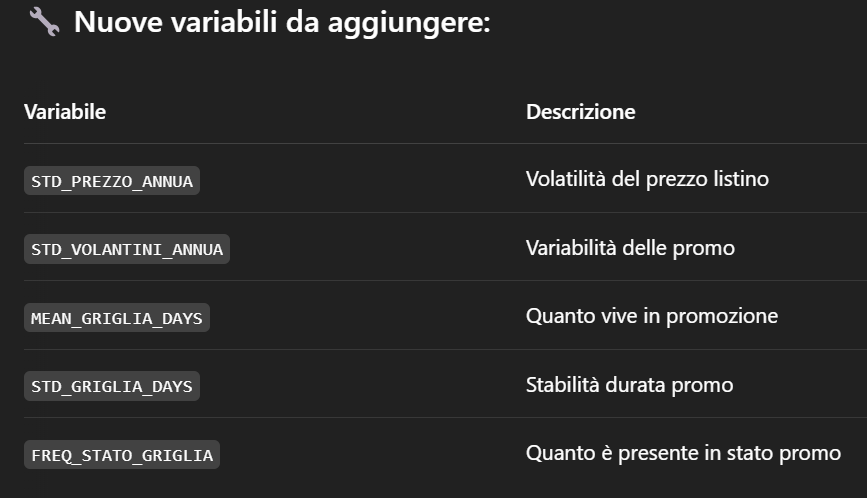

In [ ]:
# sd for prezzo_listino_medio
df['STD_PREZZO_ANNUA'] = (
    df.groupby(['ART_COD', 'YEAR'])['PREZZO_LISTINO_MEDIO']
    .transform('std')
)

#sd nvolantini
df['STD_VOLANTINI_ANNUA'] = (
    df.groupby(['ART_COD', 'YEAR'])['NVOLANTINI']
    .transform('std')
)

## IMPORTANT ANALYSIS 50% OF PRODUCTS ARE BORN IN 2023

In [ ]:
df['YEAR'].value_counts().sort_index()

In [ ]:
art_cod_lancio = df.groupby('ART_COD')['YEAR'].min().reset_index()
art_cod_lancio.columns = ['ART_COD', 'ANNO_LANCIO']

#Merge
df = df.merge(art_cod_lancio, on='ART_COD', how='left')
df['ANNO_LANCIO'].value_counts().sort_index()

In [ ]:
df_2023 = df[df['YEAR'] == 2023]
nuovi_prodotti = df_2023[df_2023['ANNO_LANCIO'] == 2023]['ART_COD'].nunique()
totale_prodotti_val = df_2023['ART_COD'].nunique()

perc_nuovi = nuovi_prodotti / totale_prodotti_val * 100
print(f" Prodotti nuovi nel 2023: {nuovi_prodotti}/{totale_prodotti_val} → {perc_nuovi:.1f}%")

In [ ]:
feature_corr_cols = [
    'QTA',
    'QTA_LAG_1', 'QTA_LAG_12',
    'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12',
    'TREND_LINEARE_12M', 'GROWTH_YOY',
    'MONTHS_SINCE_LAUNCH',
    'STD_PREZZO_ANNUA', 'STD_VOLANTINI_ANNUA',
    'FATTURATO', 'NVOLANTINI',
    'GRIGLIA_DAYS'

]

df_corr = df[feature_corr_cols].dropna()

corr_matrix = df_corr.corr().round(2)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix between Feature and QTA")
plt.show()

#XGBOOST MODELS

## MODELLO GLOBALE NO LOG


In [ ]:
feature_cols = ['QTA',
    'QTA_LAG_1', 'QTA_LAG_12',
    'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12',
    'TREND_LINEARE_12M', 'GROWTH_YOY',
    'MONTH', 'YEAR', 'MESE_IMPORTANTE', 'MONTHS_SINCE_LAUNCH',
    'PREZZO_MEDIO', 'PREZZO_LISTINO_MEDIO',
    'STD_PREZZO_ANNUA', 'STD_VOLANTINI_ANNUA',
    'NVOLANTINI', 'PRODUCT_GROUP_ENC'
]

# 1. Definition feature and target
X = df[feature_cols]
y = df['QTA']
sample_weight = df['PESO_FINALE']

# 2. Creation of a binary feature to indicate whether the SKU has history (useful for new SKUs)
X['HAS_HISTORY'] = df['QTA_LAG_12'].notna().astype(int)

# 3. Fill in NaNs ONLY on time variables with 0
temporal_cols = ['QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12', 'TREND_LINEARE_12M', 'GROWTH_YOY']
X[temporal_cols] = X[temporal_cols].fillna(0)

# 4. Aligns targets and weights to rows of X
y = y.loc[X.index]
sample_weight = sample_weight.loc[X.index]


# Let's add YEAR again to filter
X['YEAR'] = df.loc[X.index, 'YEAR']

# Temporal split
X_train = X[X['YEAR'] <= 2022].drop(columns='YEAR')
X_val = X[X['YEAR'] == 2023].drop(columns='YEAR')

y_train = y[X['YEAR'] <= 2022]
y_val = y[X['YEAR'] == 2023]

sample_weight_train = sample_weight[X['YEAR'] <= 2022]
sample_weight_val = sample_weight[X['YEAR'] == 2023]




# 1. DMatrix creation
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weight_train)
dval = xgb.DMatrix(X_val, label=y_val)

# 2. Model Parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'learning_rate': 0.03,
    'eval_metric': 'rmse',
    'seed': 42
}

# 3. Early stopping training
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1500,
    evals=[(dval, 'validation')],
    early_stopping_rounds=100,
    verbose_eval=True
)

In [ ]:
y_pred = model.predict(xgb.DMatrix(X_val))

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_pct = rmse_val / y_val.mean() * 100
print(f"RMSE: {rmse_val:.2f} | RMSE%: {rmse_pct:.2f}%")

Forecast 2024

In [ ]:
forecast_2024 = []

# I start with 2023 data as a base (from which to calculate lag and rolling)
df_forecast_base = df[df['YEAR'] == 2023].copy()

for quarter in range(1, 5):
    # I prepare the quarter to be predicted (YEAR 2024 and its MONTH)
    df_quarter = df_forecast_base.copy()
    df_quarter['YEAR'] = 2024
    df_quarter['MONTH'] = (quarter - 1) * 3 + 1  # Supponendo mesi 1,4,7,10 per Q1-Q4
    df_quarter['MONTHS_SINCE_LAUNCH'] += 3  # Aggiungi 3 mesi

    # Rebuild features
    X_quarter = df_quarter[feature_cols].copy()
    X_quarter['HAS_HISTORY'] = df_quarter['QTA_LAG_12'].notna().astype(int)
    X_quarter[temporal_cols] = X_quarter[temporal_cols].fillna(0)


    # DMatrix and prediction
    dquarter = xgb.DMatrix(X_quarter.drop(columns='YEAR'))  # Droppa YEAR qui!
    preds = model.predict(dquarter)


    # Save results
    df_quarter['QTA_PRED'] = preds
    forecast_2024.append(df_quarter[['ART_COD', 'YEAR', 'MONTH', 'QTA_PRED']])

    # Update lag and rolling for the next quarter
    df_forecast_base['QTA_LAG_1'] = preds
    df_forecast_base['QTA_LAG_12'] = df_forecast_base['QTA_LAG_12']  # Rimane la stessa, è storica
    df_forecast_base['QTA_ROLL_MEAN_3'] = (df_forecast_base['QTA_ROLL_MEAN_3'] * 2 + preds) / 3
    df_forecast_base['QTA_ROLL_MEAN_12'] = (df_forecast_base['QTA_ROLL_MEAN_12'] * 11 + preds) / 12
    df_forecast_base['TREND_LINEARE_12M'] = df_forecast_base['TREND_LINEARE_12M']  # Potresti ricalcolarla se vuoi

    # GROWTH_YOY does not update in 2024 (depends on 2023), so it may remain 0 or fixed

# Concatenates forecasted quarters
df_forecast_2024 = pd.concat(forecast_2024)

# Aggregate by quarter
df_forecast_2024['TRIMESTRE'] = pd.to_datetime(df_forecast_2024[['YEAR', 'MONTH']].assign(DAY=1)).dt.to_period('Q')
df_forecast_summary = df_forecast_2024.groupby('TRIMESTRE')['QTA_PRED'].sum().reset_index()

print(df_forecast_summary)

In [ ]:
df_forecast_2024['ART_COD'].nunique()

In [ ]:
#IMPORTANCE FEATURE
xgb.plot_importance(model, importance_type='gain', max_num_features=25)
plt.show()

#ANALISI NVOLANTINI

In [ ]:
sns.lineplot(data=df, x="NVOLANTINI", y="QTA")

In [ ]:
# Data
categories = ['Smartphones', 'Washing Machines', 'ASPIRAPOLVERE']
revenues = [350000, 180000, 150000]
colors = ['orange', 'blue', 'green']  # Smartphone orange, Washing Machines blue, Aspirapolvere green

# Plot
fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(categories, revenues, color=colors)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset sopra la barra
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Revenue (€k)')
ax.set_title('Revenue (€k)')

plt.tight_layout()
plt.show()

In [ ]:
df['NVOLANTINI'].value_counts()

In [ ]:
# INTERESTING INSIGHT: THERE ARE BOTH SCOUNTS AND SURCHARGES
df['TRIMESTRE'] = ((df['MONTH'] - 1) // 3 + 1).astype(int)
prezzi_trim = df.groupby(['ART_COD', 'YEAR', 'TRIMESTRE'])[
    ['PREZZO_MEDIO', 'PREZZO_LISTINO_MEDIO']
].mean().reset_index()

# Avoid zero or zero listings
prezzi_trim_validi = prezzi_trim[prezzi_trim['PREZZO_LISTINO_MEDIO'] > 0]

# Create surcharge flag with 2% threshold
prezzi_trim_validi['SOVRAPPREZZO'] = (
    prezzi_trim_validi['PREZZO_MEDIO'] > prezzi_trim_validi['PREZZO_LISTINO_MEDIO'] * 1.02
)
sovrapprezzi = prezzi_trim_validi[prezzi_trim_validi['SOVRAPPREZZO']]
sovrapprezzi['PREZZO_MEDIO']
sovrapprezzi['PREZZO_MEDIO'] = sovrapprezzi['PREZZO_MEDIO'].round(2)
sovrapprezzi


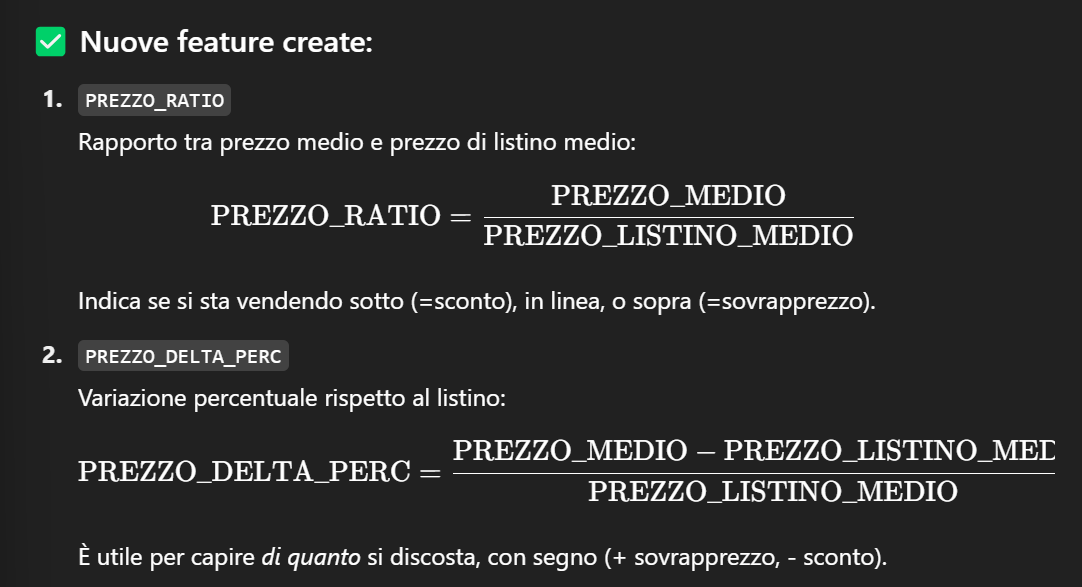

In [ ]:
df['HAS_LISTINO'] = (df['PREZZO_LISTINO_MEDIO'] > 0).astype(int)

# Create a mask for products with valid price list
mask_listino = df['HAS_LISTINO'] == 1

df.loc[mask_listino, 'PREZZO_RATIO'] = df.loc[mask_listino, 'PREZZO_MEDIO'] / df.loc[mask_listino, 'PREZZO_LISTINO_MEDIO']
df.loc[mask_listino, 'PREZZO_DELTA_PERC'] = (
    df.loc[mask_listino, 'PREZZO_MEDIO'] - df.loc[mask_listino, 'PREZZO_LISTINO_MEDIO']
) / df.loc[mask_listino, 'PREZZO_LISTINO_MEDIO']

# For those with no valid price list: PRICE_RATIO = 1 (neutral), PRICE_DELTA_PERC = 0 (no difference)
df['PREZZO_RATIO'] = df['PREZZO_RATIO'].fillna(1)
df['PREZZO_DELTA_PERC'] = df['PREZZO_DELTA_PERC'].fillna(0)

##LOG model with price variant

In [ ]:
feature_cols = [
    'QTA_LAG_1', 'QTA_LAG_12',
    'QTA_ROLL_MEAN_3','MONTH',
    'GROWTH_YOY','YEAR', 'MESE_IMPORTANTE', 'MONTHS_SINCE_LAUNCH',
    'PREZZO_RATIO','STD_VOLANTINI_ANNUA',
    'NVOLANTINI', 'PRODUCT_GROUP_ENC'
]


X = df[feature_cols].copy()
y = df['QTA']
sample_weight = df['PESO_FINALE']

y = y.loc[X.index]
sample_weight = sample_weight.loc[X.index]

X['YEAR'] = df.loc[X.index, 'YEAR']

X_train = X[X['YEAR'] <= 2022].drop(columns='YEAR')
X_val = X[X['YEAR'] == 2023].drop(columns='YEAR')

y_train = y[X['YEAR'] <= 2022]
y_val = y[X['YEAR'] == 2023]

sample_weight_train = sample_weight[X['YEAR'] <= 2022]

y_train_log = np.log1p(y_train)

dtrain = xgb.DMatrix(X_train, label=y_train_log, weight=sample_weight_train)
dval = xgb.DMatrix(X_val)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.03,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'eval_metric': 'rmse',
    'seed': 42
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train')],
    early_stopping_rounds=200,
    verbose_eval=True
)

In [ ]:
y_pred_log = model.predict(dval)
y_pred = np.expm1(np.clip(y_pred_log, a_min=None, a_max=20))  # avoid overflow

# Compute RMSE without 'squared' parameter
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

rmse_pct = rmse / y_val.mean() * 100

print(f" GLOBAL MODEL LOG with new features: RMSE: {rmse:.2f} | RMSE%: {rmse_pct:.2f}%")

In [ ]:
plt.figure(figsize=(10, 6))
plot_importance(
    model,
    importance_type='gain',
    max_num_features=20,
    height=0.5,
    show_values=True
)
plt.title("Feature Importance - Global Model with Log")
plt.tight_layout()
plt.show()

In [ ]:
# Cleaning
X_vif = X_train.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate VIF
vif_df = pd.DataFrame()
vif_df['Feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.sort_values(by='VIF', ascending=False)
display(vif_df)

## GLOBAL MODEL WITH LOG

In [ ]:
feature_cols = [
    'QTA_LAG_1', 'QTA_LAG_12',
    'QTA_ROLL_MEAN_3',
    'MONTH', 'YEAR', 'MESE_IMPORTANTE', 'MONTHS_SINCE_LAUNCH',
    'PREZZO_RATIO','HAS_LISTINO',
    'NVOLANTINI', 'PRODUCT_GROUP_ENC',
    'HAS_HISTORY'
]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

dtrain = xgb.DMatrix(X_train, label=y_train_log, weight=sample_weight_train)
dval = xgb.DMatrix(X_val, label=y_val_log)


params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'reg_alpha': 0.03,
    'reg_lambda': 0.03,
    'learning_rate': 0.03,
    'eval_metric': 'rmse',
    'seed': 42
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dval, 'validation')],
    early_stopping_rounds=200,
    verbose_eval=True
)

y_pred_log = model.predict(dval)
y_pred = np.expm1(y_pred_log)




In [ ]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_pct = rmse / y_val.mean() * 100

print(f"RMSE GLOBAL (log-transf): {rmse:.2f}")
print(f"RMSE% GLOBAL (log-transf): {rmse_pct:.2f}%")


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.4)
plt.plot([0, max(y_val)], [0, max(y_val)], 'r--')
plt.xlabel("Actual Sales (QTA)")
plt.ylabel("Forecasted")
plt.title("QTA Actual vs Forecasted – Validation")
plt.grid(True)
plt.show()


##DIVIDED MODELS PER PRODUCT_GROUP

In [ ]:

def train_and_evaluate_group(df_group, group_name):
    print(f"\n Processing: {group_name}")

    feature_cols = [
        'QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12',
        'TREND_LINEARE_12M', 'GROWTH_YOY',
        'MONTH', 'YEAR', 'MESE_IMPORTANTE', 'MONTHS_SINCE_LAUNCH',
        'PREZZO_RATIO', 'HAS_LISTINO',
        'STD_PREZZO_ANNUA', 'STD_VOLANTINI_ANNUA',
        'NVOLANTINI', 'PRODUCT_GROUP_ENC'
    ]

    df_group['HAS_HISTORY'] = df_group['QTA_LAG_12'].notna().astype(int)
    feature_cols.append('HAS_HISTORY')

    X = df_group[feature_cols]
    y = df_group['QTA']
    sample_weight = df_group['PESO_FINALE']

    temporal_cols = ['QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12', 'TREND_LINEARE_12M', 'GROWTH_YOY']
    X[temporal_cols] = X[temporal_cols].fillna(0)

    y = y.loc[X.index]
    sample_weight = sample_weight.loc[X.index]

    # Target Log-transform
    y_log = np.log1p(y)

    # Split train/val
    X_train = X[X['YEAR'] <= 2022]
    X_val = X[X['YEAR'] == 2023]
    y_train = y_log[X['YEAR'] <= 2022]
    y_val = y[X['YEAR'] == 2023]
    sw_train = sample_weight[X['YEAR'] <= 2022]


    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sw_train)
    dval = xgb.DMatrix(X_val)


    params = {
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'reg_alpha': 0.03,
        'reg_lambda': 0.05,
        'learning_rate': 0.03,
        'eval_metric': 'rmse',
        'seed': 42
    }

    # Train
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        early_stopping_rounds=200,
        evals=[(dtrain, 'train')],
        verbose_eval=False
    )

    # Predict
    y_pred_log = model.predict(dval)
    y_pred = np.expm1(y_pred_log)

    # RMSE + RMSE%
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_pct = rmse / y_val.mean() * 100

    print(f" RMSE ({group_name}): {rmse:.2f} | RMSE%: {rmse_pct:.2f}%")


In [ ]:
# We apply the function to the three groups
train_and_evaluate_group(df[df['PRODUCT_GROUP'] == 'ASPIRAPOLVERE'], 'ASPIRAPOLVERE')
train_and_evaluate_group(df[df['PRODUCT_GROUP'] == 'SMARTPHONES'], 'SMARTPHONES')
train_and_evaluate_group(df[df['PRODUCT_GROUP'] == 'WASHINGMACHINES'], 'WASHINGMACHINES')


## DISCOVERY: IN 2023 50% OF PRODUCTS HAVE NO HISTORICAL, THEY CAME OUT THAT YEAR.. LET'S CHECK IT BETTER AND DIVIDE THE QTA TO BE PREDICTED: WE WILL USE XGBOOST ONLY FOR ARTCODS WITH HISTORICAL DATA, FOR THOSE THAT CAME OUT IN 2023 INSTEAD WE WILL APPLY ANOTHER PLAN

In [ ]:
df_2023 = df[df['YEAR'] == 2023]

total_products_2023 = df_2023['ART_COD'].nunique()

new_products_2023 = df_2023[df_2023['ANNO_LANCIO'] == 2023]['ART_COD'].nunique()

percentage_new_products = (new_products_2023 / total_products_2023) * 100

print(f"In 2023, around {percentage_new_products:.2f}% products is new.")


#MODEL XGBOOST W/OUT LOG FOR OLD ART_COD

In [ ]:
df_old = df[df['ANNO_LANCIO'] < 2023].copy()

feature_cols = [
    'QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12',
    'TREND_LINEARE_12M', 'GROWTH_YOY',
    'MONTH', 'YEAR', 'MESE_IMPORTANTE', 'MONTHS_SINCE_LAUNCH',
    'PREZZO_MEDIO', 'PREZZO_LISTINO_MEDIO',
    'STD_PREZZO_ANNUA', 'STD_VOLANTINI_ANNUA',
    'NVOLANTINI', 'PRODUCT_GROUP_ENC'
]

X = df_old[feature_cols].copy()
y = df_old['QTA']
sample_weight = df_old['PESO_FINALE']

X['HAS_HISTORY'] = df_old['QTA_LAG_12'].notna().astype(int)
feature_cols.append('HAS_HISTORY')

temporal_cols = ['QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12', 'TREND_LINEARE_12M', 'GROWTH_YOY']
X[temporal_cols] = X[temporal_cols].fillna(0)

y = y.loc[X.index]
sample_weight = sample_weight.loc[X.index]

X_train = X[X['YEAR'] <= 2022]
X_val = X[X['YEAR'] == 2023]

y_train = y[X['YEAR'] <= 2022]
y_val = y[X['YEAR'] == 2023]
sw_train = sample_weight[X['YEAR'] <= 2022]

dtrain = xgb.DMatrix(X_train, label=y_train, weight=sw_train)
dval = xgb.DMatrix(X_val)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    'learning_rate': 0.03,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'eval_metric': 'rmse',
    'seed': 42
}

# TRAINING
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=3000,
    evals=[(dtrain, 'train')],
    early_stopping_rounds=200,
    verbose_eval=True
)

# PREDICTION and METRICS
y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_pct = rmse / y_val.mean() * 100

print(f"RMSE (no-log, storico): {rmse:.2f} | RMSE%: {rmse_pct:.2f}%")

## MODEL LIGHTGBM

In [ ]:
train_set = lgb.Dataset(X_train, label=y_train_log, weight=sw_train)
val_set = lgb.Dataset(X_val, label=np.log1p(y_val), reference=train_set)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.07,
    'max_depth': 7,
    'lambda_l1': 0.001,
    'lambda_l2': 0.001,
    'subsample': 0.99,
    'colsample_bytree': 0.8,
    'min_split_gain': 0.01,
    'seed': 42
}

# Training
model_lgb = lgb.train(
    params,
    train_set,
    num_boost_round=3000,
    valid_sets=[train_set, val_set],
    callbacks=[
        lgb.early_stopping(500),
        lgb.log_evaluation(100)
    ]
)

In [ ]:
# Prediction log + inverse
y_pred_log = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
y_pred = np.expm1(np.clip(y_pred_log, a_min=0, a_max=20))

# Calcolo RMSE
mse = mean_squared_error(y_val, y_pred)  # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE manually

rmse_pct = rmse / y_val.mean() * 100

print(f"LightGBM - RMSE: {rmse:.2f} | RMSE%: {rmse_pct:.2f}%")



---

## Recap activities performed.

### 1. Preparation of the dataset.
- We filtered the dataset to include only those products with **historical available** (`YEARLY_YEAR < 2023`)
- Cleanup of missing values for temporal variables using `fillna(0)`
- Creation of feature `HAS_HISTORY`(dummy) to indicate the presence of historical, this is because the model was also forecasting products that it had not my seen in the train and I excluded them, need to think of another way to forecast them.

### 2. Model construction.
- We trained a **XGBoost Regressor** model with **logarithmic transformation** of the target (`log1p(QTA)`) --> this is because QTA was too skewed and so if we had QTApred2023= 5 and QTAreal2023= 10 we were erring by 50% in our model.
- The model was trained with `sample_weight` to give more importance to the most recent years and penalize 2020 and also to the months Q3-Q4

### 3. Evaluation on validation set
- The validation set consists of data from the year 2023 (only products with history).
- After inverse logarithm (`expm1`), we obtained:
  - RMSE: 121.17
  - RMSE%: 119.66% the lows I was able to do

  I also tried working on dataset divided by product_group and it was actually working I don't know why I stopped.

### 4. Cross-validation
- A 5-fold cross-validation was performed on `df_old`.
- The best RMSE obtained on log scale is 0.63, equivalent to ~1.88 units on average
- The final model retrained with the optimal number of rounds gave:
  - RMSE: 124.70
  - RMSE%: 123.15%
This made us realize the model generalizes well (should generalize well actually)

### 5. Conclusion
- The model with logarithm without CV remains the best performing model
- It was shown that the room for improvement is related to new features or alternative strategies

---

## MODEL XGBOOST WITH LOG FOR OLD ART COD WITH PREZZO RATIO

# sinusoid XGBOOST

In [ ]:

df = df.copy()

# YEAR + MONTH WEIGHTS
df['MESE_IMPORTANTE'] = df['MONTH'].apply(lambda x: 1 if x >= 8 else 0)
peso_anno_dict = {2023: 1.0, 2022: 0.9, 2021: 0.8, 2020: 0.3, 2019: 0.7, 2018: 0.6, 2017: 0.5}
peso_mese_dict = {1: 0.4, 2: 0.4, 3: 0.5, 4: 0.5, 5: 0.6, 6: 0.7, 7: 0.8, 8: 0.9, 9: 0.95, 10: 1.0, 11: 1.0, 12: 1.0}
df['PESO_ANNO'] = df['YEAR'].map(peso_anno_dict)
df['PESO_MESE'] = df['MONTH'].map(peso_mese_dict)
df['PESO_FINALE'] = df['PESO_ANNO'] * df['PESO_MESE']
df['PESO_FINALE'].fillna(0.5, inplace=True)

# SEASONAL SINUSOID
df['SIN_MONTH'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['COS_MONTH'] = np.cos(2 * np.pi * df['MONTH'] / 12)

# FEATURES
feature_cols = ['FATTURATO','QTA', 'QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12',
          'TREND_LINEARE_12M', 'MONTH', 'GROWTH_YOY', 'MONTHS_SINCE_LAUNCH',
                'PREZZO_RATIO', 'STD_VOLANTINI_ANNUA', 'NVOLANTINI', 'PRODUCT_GROUP_ENC',
                'SIN_MONTH', 'COS_MONTH']

df_old = df[df['ANNO_LANCIO'] < 2023].copy()
X = df_old[feature_cols].copy()
y = df_old['QTA']
sample_weight = df_old['PESO_FINALE']

# SPLIT TRAIN / VALIDATION
X_train = X[df_old['YEAR'] <= 2022]
X_val = X[df_old['YEAR'] == 2023]
y_train = y[df_old['YEAR'] <= 2022]
y_val = y[df_old['YEAR'] == 2023]
sw_train = sample_weight[df_old['YEAR'] <= 2022]


# DMATRIX
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sw_train)
dval = xgb.DMatrix(X_val)

### --- 2. TRAINING MODEL ---
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.05,
    'reg_alpha': 0.7,
    'reg_lambda': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric': 'rmse',
    'seed': 42
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=3000,
    evals=[(dtrain, 'train')],
    early_stopping_rounds=200,
    verbose_eval=False
)

### --- 3. FORECAST TRAIN + VALIDATION ---
# Train
y_pred_train_log = model.predict(dtrain)
y_pred_train = model.predict(dtrain)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
rmse_pct_train = rmse_train / y_train.mean() * 100

# Validation
y_pred_val_log = model.predict(dval)
y_pred_val = model.predict(dval)
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
rmse_pct_val = rmse_val / y_val.mean() * 100

print(f"Train RMSE: {rmse_train:.2f} | RMSE%: {rmse_pct_train:.2f}%")
print(f"Validation RMSE: {rmse_val:.2f} | RMSE%: {rmse_pct_val:.2f}%")

### --- 4. FORECAST 2024 ---

art_cod_storico = df_old['ART_COD'].unique()
months_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').to_period('M')
forecast_grid = pd.MultiIndex.from_product([art_cod_storico, months_2024], names=['ART_COD', 'ANNOMESE']).to_frame(index=False)


latest_features = df_old.sort_values('ANNOMESE').groupby('ART_COD').last().reset_index()
X_forecast_2024 = forecast_grid.merge(latest_features, on='ART_COD', how='left')
X_forecast_2024['YEAR'] = 2024
X_forecast_2024['MONTH'] = X_forecast_2024['ANNOMESE_x'].dt.month


X_forecast_2024['SIN_MONTH'] = np.sin(2 * np.pi * X_forecast_2024['MONTH'] / 12)
X_forecast_2024['COS_MONTH'] = np.cos(2 * np.pi * X_forecast_2024['MONTH'] / 12)


X_model_forecast = X_forecast_2024[feature_cols].copy()
dforecast = xgb.DMatrix(X_model_forecast)


y_pred_log_2024 = model.predict(dforecast)
y_pred_2024 = model.predict(dforecast)
X_forecast_2024['QTA_FORECAST_2024'] = y_pred_2024


rmse_forecast = np.sqrt(np.mean((X_forecast_2024['QTA_FORECAST_2024']) ** 2))
print(f" Forecast 2024 RMSE: {rmse_forecast:.2f}")

### --- 5. FEATURE IMPORTANCE ---
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax, importance_type='gain', max_num_features=15)
plt.title("Feature Importance")
plt.show()


In [ ]:
# We start with X_forecast_2024 which has ANNOMESE_x and QTA_FORECAST_2024
# We take only the useful columns

df_forecast_final = X_forecast_2024[['ART_COD', 'ANNOMESE_x', 'MONTH', 'QTA_FORECAST_2024']].copy()

df_forecast_final['DATE'] = df_forecast_final['ANNOMESE_x'].dt.to_timestamp()

df_forecast_final = df_forecast_final[['ART_COD', 'DATE', 'MONTH', 'QTA_FORECAST_2024']]

df_forecast_final = df_forecast_final.sort_values(['ART_COD', 'DATE']).reset_index(drop=True)

df_forecast_final.head()


In [ ]:
df_agg = df_forecast_final.groupby('DATE')['QTA_FORECAST_2024'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_agg['DATE'], df_agg['QTA_FORECAST_2024'], marker='o')
plt.title('Forecast 2024')
plt.xlabel('Date')
plt.ylabel('Forecasted Quantity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Old XGBoost

In [ ]:
df_old = df[df['ANNO_LANCIO'] < 2023].copy()

feature_cols = ['FATTURATO','QTA',
'MONTH', 'GROWTH_YOY',
'YEAR','MONTHS_SINCE_LAUNCH',
'PREZZO_RATIO', 'STD_VOLANTINI_ANNUA',
'NVOLANTINI', 'PRODUCT_GROUP_ENC'
]


X = df_old[feature_cols].copy()
y = df_old['QTA']
sample_weight = df_old['PESO_FINALE']


y = y.loc[X.index]
sample_weight = sample_weight.loc[X.index]



X_train = X[X['YEAR'] <= 2022]
X_val = X[X['YEAR'] == 2023]

y_train = y[X['YEAR'] <= 2022]
y_val = y[X['YEAR'] == 2023]

sw_train = sample_weight[X['YEAR'] <= 2022]

feature_cols = [col for col in feature_cols if col != 'YEAR']
X_train = X_train[feature_cols]
X_val = X_val[feature_cols]

y_train_log = np.log1p(y_train)


dtrain = xgb.DMatrix(X_train, label=y_train_log, weight=sw_train)
dval = xgb.DMatrix(X_val)


params = {
    'objective': 'reg:squarederror',
'max_depth': 5, 'learning_rate': 0.05467790959199914, 'reg_alpha': 0.7896854761987117, 'reg_lambda': 0.0841592946658499,
'subsample': 0.7428665735425133, 'colsample_bytree': 0.9258037104927725,
    'eval_metric': 'rmse',
    'seed': 42
}


model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=3000,
    evals=[(dtrain, 'train')],
    early_stopping_rounds=200,
    verbose_eval=True
)


In [ ]:
y_pred_log = model.predict(dval)
y_pred = np.expm1(np.clip(y_pred_log, a_min=None, a_max=20))  # avoid overflow


mse = mean_squared_error(y_val, y_pred)  # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE from MSE

rmse_pct = rmse / y_val.mean() * 100

print(f"RMSE: {rmse:.2f} | RMSE%: {rmse_pct:.2f}%")

In [ ]:
# TRAIN PREDICTION
y_pred_log_train = model.predict(dtrain)
y_pred_train = np.expm1(np.clip(y_pred_log_train, a_min=None, a_max=20))

# VALIDATION PREDICTION
y_pred_log_val = model.predict(dval)
y_pred_val = np.expm1(np.clip(y_pred_log_val, a_min=None, a_max=20))


mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
rmse_pct_train = rmse_train / y_train.mean() * 100

mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
rmse_pct_val = rmse_val / y_val.mean() * 100

print(f"Train RMSE: {rmse_train:.2f} | RMSE%: {rmse_pct_train:.2f}%")
print(f"Validation RMSE: {rmse_val:.2f} | RMSE%: {rmse_pct_val:.2f}%")


In [ ]:
#Plot
fig, ax = plt.subplots(figsize=(10, 8))

xgb.plot_importance(
    model,
    ax=ax,
    importance_type='gain',
    max_num_features=20,
    xlabel='Gain',
    height=0.5
)

plt.title("Feature Importance (XGBoost)")
plt.show()


In [ ]:
#VIF to capture comfounder
X_train_vif = X_train.copy()


X_train_vif = X_train_vif.replace([np.inf, -np.inf], np.nan).dropna()


vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_vif.columns
vif_data['VIF'] =[
    variance_inflation_factor(X_train_vif.values, i)
    for i in range(X_train_vif.shape[1])
]

vif_data = vif_data.sort_values(by='VIF', ascending=False)
display(vif_data)


In [ ]:
# WE TRY TO FURTHER IMPROVE THE MODEL
# HYPERPARAMETER OPTIMIZATION WITH OPTUNA

def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.07),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'seed': 42
    }


    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dtrain, 'train')],
        early_stopping_rounds=100,
        verbose_eval=False
    )


    y_pred_log = model.predict(dval)
    y_pred = np.expm1(np.clip(y_pred_log, a_min=0, a_max=20))


    mse = mean_squared_error(y_val, y_pred)  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE from MSE
    return rmse
# Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  #  trials

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)


In [ ]:
# 6. Forecast 2024 on df
X_forecast_2024 = df_old[df_old['YEAR'] == 2024][feature_cols]
dforecast = xgb.DMatrix(X_forecast_2024)

y_pred_log_2024 = model.predict(dforecast)
y_pred_2024 = np.expm1(np.clip(y_pred_log_2024, a_min=0, a_max=20))

# 7. Clean df_2024
df_2024 = df_old[df_old['YEAR'] == 2024].copy()
df_2024['QTA_FORECAST_2024'] = y_pred_2024



#FORECAST OLD ART_COD AND NEW


In [ ]:
an_prod_test['ART_COD'].nunique()
info_bs_test['ART_COD'].nunique()

In [ ]:
art_cod_storico = df['ART_COD'].unique()
an_prod_test['HAS_STORICO'] = an_prod_test['ART_COD'].isin(art_cod_storico).astype(int)
an_prod_test.groupby('HAS_STORICO')['ART_COD'].nunique()

In [ ]:
df_old['ART_COD'].nunique()

# old


In [ ]:
art_cod_storico = df_old['ART_COD'].unique()

# 2. Construct ART_COD grid × months of 2024
months_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').to_period('M')
forecast_grid = pd.MultiIndex.from_product([art_cod_storico, months_2024], names=['ART_COD', 'ANNOMESE']).to_frame(index=False)

# 3. Merge with df_old to inherit features (take last available info for each ART_COD)
latest_features = df_old.sort_values('ANNOMESE').groupby('ART_COD').last().reset_index()
X_forecast_2024 = forecast_grid.merge(latest_features, on='ART_COD', how='left')

# 4. Update MONTH and YEAR directly from the grid
X_forecast_2024['YEAR'] = 2024
X_forecast_2024['MONTH'] = forecast_grid['ANNOMESE'].dt.month

X_model = X_forecast_2024[model.feature_names].copy()  # Use model.feature_names for column selection

for col in model.feature_names:
    if col not in X_model.columns:
        X_model[col] = 0


# 5. Prepares features for the model (excluding YEAR)
X_model = X_model.drop(columns=['YEAR'], errors='ignore')
dforecast = xgb.DMatrix(X_model)
for col in ['FATTURATO', 'QTA']:
    if col not in X_forecast_2024.columns:
        X_forecast_2024[col] = 0

# 6. Prediction
y_pred_log_2024 = model.predict(dforecast)
y_pred_2024 = np.expm1(np.clip(y_pred_log_2024, a_min=0, a_max=20))

X_forecast_2024['QTA_FORECAST_2024'] = y_pred_2024
df_forecast_final1 = X_forecast_2024[['ART_COD', 'MONTH', 'QTA_FORECAST_2024']]


# Another model WITHOUT LOG

OLD

In [ ]:
feature_cols = [
    'FATTURATO', 'QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12',
    'TREND_LINEARE_12M', 'MONTH', 'GROWTH_YOY', 'MONTHS_SINCE_LAUNCH',
    'PREZZO_RATIO', 'STD_VOLANTINI_ANNUA', 'NVOLANTINI', 'PRODUCT_GROUP_ENC',
    'SIN_MONTH', 'COS_MONTH'
]


df_train = df[df['YEAR'] <= 2022].copy()
df_val = df[df['YEAR'] == 2023].copy()

X_train = df_train[feature_cols]
y_train = df_train['QTA']
X_val = df_val[feature_cols]
y_val = df_val['QTA']


X_train = X_train.fillna(0)
X_val = X_val.fillna(0)


dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)


params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.03,
    'eval_metric': 'rmse',
    'seed': 42
}

evals = [(dtrain, 'train'), (dval, 'validation')]
model = xgb.train(params, dtrain, num_boost_round=500, evals=evals, early_stopping_rounds=20)

val_predictions = model.predict(dval)
val_rmse = np.sqrt(np.mean((y_val - val_predictions) ** 2))
print(f"Validation RMSE (2023): {val_rmse:.2f}")


art_cod_storico = df_old['ART_COD'].unique()

months_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').to_period('M')
forecast_grid = pd.MultiIndex.from_product([art_cod_storico, months_2024], names=['ART_COD', 'ANNOMESE']).to_frame(index=False)

latest_features = df_old.sort_values('ANNOMESE').groupby('ART_COD').last().reset_index()
X_forecast_2024 = forecast_grid.merge(latest_features, on='ART_COD', how='left')

X_forecast_2024['YEAR'] = 2024
X_forecast_2024['MONTH'] = forecast_grid['ANNOMESE'].dt.month

X_model = X_forecast_2024[feature_cols].copy()
X_model = X_model.fillna(0)
dforecast = xgb.DMatrix(X_model)

y_pred_2024 = model.predict(dforecast)
X_forecast_2024['QTA_FORECAST_2024'] = y_pred_2024

df_forecast_final = X_forecast_2024[['ART_COD', 'MONTH', 'QTA_FORECAST_2024']]
print(df_forecast_final.head())

In [ ]:
#Importance
importance = model.get_score(importance_type='weight')


importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=True)


plt.figure(figsize=(8,6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='darkblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost - Weight)')
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Calculates the RMSE on the validation set
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f"Expected RMSE (validation 2023): {rmse:.2f}")


In [ ]:
# Create column TRIMESTRE
df_forecast_final['TRIMESTRE'] = ((df_forecast_final['MONTH'] - 1) // 3) + 1

# Aggregates forecasted quantities by quarter
df_trimestri = df_forecast_final.groupby('TRIMESTRE')['QTA_FORECAST_2024'].sum().reset_index()

plt.figure(figsize=(8, 5))
plt.plot(df_trimestri['TRIMESTRE'], df_trimestri['QTA_FORECAST_2024'], marker='o', linestyle='-')
plt.title('Total Forecasted Quantity per Quarter (2024)')
plt.xlabel('Quarter')
plt.ylabel('Total Forecasted Quantity')
plt.xticks([1, 2, 3, 4])
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

art_cod_storico = df['ART_COD'].unique()

an_prod_test['HAS_STORICO'] = an_prod_test['ART_COD'].isin(art_cod_storico).astype(int)

df_new = an_prod_test[an_prod_test['HAS_STORICO'] == 0].copy()



## WE DIVIDE BY GRID_STATE, FIRST THE GLOBALS, THEN I'LL DIVIDE THE MODELS BY BOTH PRODUCT_GROUP AND GRID_STATE

In [ ]:
df['STATO_GRIGLIA'].value_counts()

In [117]:
griglia_validi = ['E', '1', 'B', 'X', '2', '3', 'M']

# Simplified column
df['STATO_GRIGLIA_CLEAN'] = df['STATO_GRIGLIA'].apply(lambda x: x if x in griglia_validi else 'ALTRO')

# Cycle on each grid state
for stato in df['STATO_GRIGLIA_CLEAN'].unique():
    print(f"\nProcessing STATO_GRIGLIA: {stato}")
    df_stato = df[df['STATO_GRIGLIA_CLEAN'] == stato].copy()

    # ---- Feature setup ----
    feature_cols = [
        'QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12',
        'TREND_LINEARE_12M', 'GROWTH_YOY',
        'MONTH', 'YEAR', 'MESE_IMPORTANTE', 'MONTHS_SINCE_LAUNCH',
        'PREZZO_MEDIO', 'PREZZO_LISTINO_MEDIO',
        'STD_PREZZO_ANNUA', 'STD_VOLANTINI_ANNUA',
        'NVOLANTINI', 'PRODUCT_GROUP_ENC'
    ]
    X = df_stato[feature_cols].copy()
    y = df_stato['QTA']
    sample_weight = df_stato['PESO_FINALE']


    temporal_cols = ['QTA_LAG_1', 'QTA_LAG_12', 'QTA_ROLL_MEAN_3', 'QTA_ROLL_MEAN_12', 'TREND_LINEARE_12M', 'GROWTH_YOY']
    X[temporal_cols] = X[temporal_cols].fillna(0)


    X_train = X[X['YEAR'] <= 2022]
    X_val = X[X['YEAR'] == 2023]
    y_train = y.loc[X_train.index]
    y_val = y.loc[X_val.index]
    sw_train = sample_weight.loc[X_train.index]

    # Skip if the group does not have enough data
    if len(X_train) == 0 or len(X_val) == 0:
        print(f"Skipping STATO_GRIGLIA: {stato} (no training or validation data)")
        continue

    # ---- Model ----
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sw_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01,
        'learning_rate': 0.03,
        'eval_metric': 'rmse',
        'seed': 42
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=170,
        verbose_eval=True
    )


    y_pred = model.predict(dval)

    rmse = mean_squared_error(y_val, y_pred) ** 0.5 #new
    rmse_pct = rmse / y_val.mean() * 100

    print(f"RMSE ({stato}): {rmse:.2f} | RMSE%: {rmse_pct:.2f}%")


Processing STATO_GRIGLIA: ALTRO
[0]	validation-rmse:112.38723
[1]	validation-rmse:110.57047
[2]	validation-rmse:108.80570
[3]	validation-rmse:107.11330
[4]	validation-rmse:105.60530
[5]	validation-rmse:104.01848
[6]	validation-rmse:102.71802
[7]	validation-rmse:101.45406
[8]	validation-rmse:100.27135
[9]	validation-rmse:99.14727
[10]	validation-rmse:98.01900
[11]	validation-rmse:96.82597
[12]	validation-rmse:95.70883
[13]	validation-rmse:94.66082
[14]	validation-rmse:93.63363
[15]	validation-rmse:92.78380
[16]	validation-rmse:91.95534
[17]	validation-rmse:91.19303
[18]	validation-rmse:90.49384
[19]	validation-rmse:89.77117
[20]	validation-rmse:89.18064
[21]	validation-rmse:88.49484
[22]	validation-rmse:87.91120
[23]	validation-rmse:87.35398
[24]	validation-rmse:86.85405
[25]	validation-rmse:86.17088
[26]	validation-rmse:85.72513
[27]	validation-rmse:84.89569
[28]	validation-rmse:84.31109
[29]	validation-rmse:83.90528
[30]	validation-rmse:83.39378
[31]	validation-rmse:82.93198
[32]	val

In [118]:
art_cod_storico = df['ART_COD'].unique()
an_prod_test['HAS_STORICO'] = an_prod_test['ART_COD'].isin(art_cod_storico).astype(int)
df_new = an_prod_test[an_prod_test['HAS_STORICO'] == 0].copy()

#MODEL NEW

In [ ]:
df_new

In [ ]:
#UPLIFT MODEL
# Prepare new ART_CODs without historical
an_prod_test['PRODUCT_GROUP'] = an_prod_test['PRODUCT_GROUP'].replace('WASHINGMACHINES FREESTANDING', 'WASHINGMACHINES')
df_new = an_prod_test[~an_prod_test['ART_COD'].isin(df_old['ART_COD'].unique())].drop_duplicates(subset='ART_COD').copy()

months_2024 = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').to_period('M')
forecast_grid_new = pd.MultiIndex.from_product(
    [df_new['ART_COD'].unique(), months_2024], names=['ART_COD', 'MONTH']
).to_frame(index=False)

media_group = df[df['YEAR'] == 2023].groupby('PRODUCT_GROUP')['QTA'].mean().reset_index()
media_group.rename(columns={'QTA': 'MEDIA_GROUP'}, inplace=True)

# Calculates uplift for each ART_COD relative to its PRODUCT_GROUP
uplift = df[df['YEAR'] == 2023].groupby(['PRODUCT_GROUP', 'ART_COD'])['QTA'].mean().reset_index()
uplift = uplift.merge(media_group, on='PRODUCT_GROUP', how='left')
uplift['UPLIFT'] = uplift['QTA'] / uplift['MEDIA_GROUP']

uplift_medio = uplift.groupby('PRODUCT_GROUP')['UPLIFT'].median().reset_index()
uplift_medio.rename(columns={'UPLIFT': 'UPLIFT_MEDIANO'}, inplace=True)

# Join medium uplift to new ART_CODs
df_new = df_new.merge(uplift_medio, on='PRODUCT_GROUP', how='left')

# Merge forecast grid with info from new ART_CODs
df_forecast_new = forecast_grid_new.merge(df_new[['ART_COD', 'PRODUCT_GROUP', 'UPLIFT_MEDIANO']], on='ART_COD', how='left')

df_forecast_new = df_forecast_new.merge(media_group, on='PRODUCT_GROUP', how='left')

# Calculate the base forecast without seasonality
df_forecast_new['QTA_FORECAST_2024'] = df_forecast_new['MEDIA_GROUP'] * df_forecast_new['UPLIFT_MEDIANO']

# Applies quarterly seasonality
stagionalita = {
    1: 0.15,  # Q1
    2: 0.20,  # Q2
    3: 0.20,  # Q3
    4: 0.45   # Q4
}


df_forecast_new['TRIMESTRE'] = df_forecast_new['MONTH'].dt.quarter

df_forecast_new['QTA_FORECAST_2024'] *= df_forecast_new['TRIMESTRE'].map(stagionalita)

df_forecast_new = df_forecast_new[['ART_COD', 'MONTH', 'TRIMESTRE', 'QTA_FORECAST_2024']]

print(df_forecast_new.head())

In [ ]:
# Aggregate the total quantity by QUARTER in the df_forecast_new
trimestre_new = df_forecast_new.groupby('TRIMESTRE')['QTA_FORECAST_2024'].sum().reset_index()

plt.figure(figsize=(8,5))
plt.plot(trimestre_new['TRIMESTRE'], trimestre_new['QTA_FORECAST_2024'], marker='o', linestyle='-', color='green')
plt.xlabel('Quarter')
plt.ylabel('Total Forecasted Quantity (New ART_COD)')
plt.title('Total Forecasted Quantity per Quarter - New ART_COD (2024)')
plt.xticks([1, 2, 3, 4])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Merge Old and New

In [ ]:

# For df_forecast_final (where 'MONTH' is probably numeric).
if pd.api.types.is_integer_dtype(df_forecast_final['MONTH']):
    df_forecast_final['MONTH'] = pd.to_datetime('2024-' + df_forecast_final['MONTH'].astype(str) + '-01').dt.to_period('M')

# For df_forecast_new (where 'MONTH' should already be Period[M])
if not pd.api.types.is_period_dtype(df_forecast_new['MONTH']):
    df_forecast_new['MONTH'] = pd.to_datetime(df_forecast_new['MONTH']).dt.to_period('M')

df_forecast_final['TRIMESTRE'] = df_forecast_final['MONTH'].dt.quarter
df_forecast_new['TRIMESTRE'] = df_forecast_new['MONTH'].dt.quarter

df_unione = pd.concat([df_forecast_final, df_forecast_new], ignore_index=True)

df_totale_annuale = df_unione.groupby('ART_COD').agg({
    'QTA_FORECAST_2024': 'sum'
}).reset_index().rename(columns={'QTA_FORECAST_2024': 'QTA_FORECAST_2024_TOTALE'})

df_per_trimestre = df_unione.groupby(['ART_COD', 'TRIMESTRE']).agg({
    'QTA_FORECAST_2024': 'sum'
}).reset_index().rename(columns={'QTA_FORECAST_2024': 'QTA_FORECAST_2024_TRIMESTRALE'})

print("Dataset Totale Annuale")
print(df_totale_annuale.head())

print("\nDataset per Trimestre")
print(df_per_trimestre.head())


In [ ]:

df_real_2023 = df[df['YEAR'] == 2023].copy()

df_real_2023['MONTH_PERIOD'] = pd.to_datetime(df_real_2023['YEAR'].astype(str) + '-' + df_real_2023['MONTH'].astype(str) + '-01').dt.to_period('M')

df_real_2023['TRIMESTRE'] = df_real_2023['MONTH_PERIOD'].dt.quarter

df_real_trimestre = df_real_2023.groupby(['ART_COD', 'TRIMESTRE'])['QTA'].sum().reset_index()

# merge between forecast and actual
df_merge_val = df_per_trimestre.merge(df_real_trimestre, on=['ART_COD', 'TRIMESTRE'], how='inner')

rmse_merge = np.sqrt(mean_squared_error(df_merge_val['QTA'], df_merge_val['QTA_FORECAST_2024_TRIMESTRALE']))
print(f"Expected RMSE (Merge 2023 vs Forecast 2024): {rmse_merge:.2f}")


In [ ]:

art_cod_test = lista_test['ART_COD'].unique()
all_present = all(art_cod in df_totale_annuale['ART_COD'].values for art_cod in art_cod_test)

# Print the result
if all_present:
  print("Tutti gli ART_COD di lista_test sono presenti in df_totale_annuale.")
else:
  print("Non tutti gli ART_COD di lista_test sono presenti in df_totale_annuale.")

# Find the ART_CODs that are not present
missing_art_cod = set(art_cod_test) - set(df_totale_annuale['ART_COD'].values)
if missing_art_cod:
    print("\nART_COD mancanti:", missing_art_cod)


# DF DELIVERABLE

In [ ]:
df_consegna = df_totale_annuale[df_totale_annuale['ART_COD'].isin(lista_test['ART_COD'])].copy()

df_consegna

In [ ]:

df_consegna.to_csv('df_consegna.csv', index=False)
files.download('df_consegna.csv')

In [ ]:

trimestre_totale = df_per_trimestre.groupby('TRIMESTRE')['QTA_FORECAST_2024_TRIMESTRALE'].sum().reset_index()


plt.figure(figsize=(8,5))
plt.plot(trimestre_totale['TRIMESTRE'], trimestre_totale['QTA_FORECAST_2024_TRIMESTRALE'], marker='o', linestyle='-', color='blue')
plt.xlabel('Quarter')
plt.ylabel('Total Forecasted Quantity')
plt.title('Total Forecasted Quantity per Quarter - 2024')
plt.xticks([1, 2, 3, 4])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
df_2023 = df[df['YEAR'] == 2023].copy()

if 'TRIMESTRE' not in df_2023.columns:
    df_2023['TRIMESTRE'] = df_2023['MONTH'].apply(lambda x: ((x - 1) // 3) + 1)


df_2023_grouped = df_2023.groupby('TRIMESTRE')['QTA'].sum().reset_index()
df_2023_grouped['ANNO'] = 2023

# ---- Quantity 2024 ----
df_2024_grouped = df_unione.groupby('TRIMESTRE')['QTA_FORECAST_2024'].sum().reset_index()
df_2024_grouped.rename(columns={'QTA_FORECAST_2024': 'QTA'}, inplace=True)
df_2024_grouped['ANNO'] = 2024


df_plot = pd.concat([df_2023_grouped, df_2024_grouped])


df_plot['TRIMESTRE'] = df_plot['TRIMESTRE'].apply(lambda x: x.quarter if isinstance(x, pd.Period) else x)


plt.figure(figsize=(8, 5))
for anno in df_plot['ANNO'].unique():
    subset = df_plot[df_plot['ANNO'] == anno]
    plt.plot(subset['TRIMESTRE'], subset['QTA'], marker='o', label=f'Anno {anno}')

plt.title('Quantità Totale per Trimestre: 2023 vs 2024')
plt.xlabel('Trimestre')
plt.ylabel('Quantità Totale')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

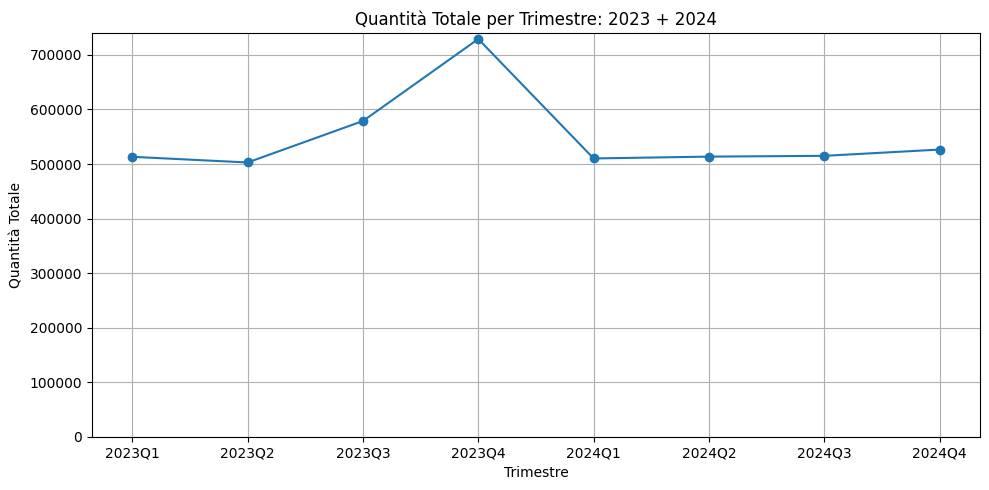

In [120]:
# ---- Quantity 2023 ----
df_2023 = df[df['YEAR'] == 2023].copy()

if 'TRIMESTRE' not in df_2023.columns:
    df_2023['TRIMESTRE'] = df_2023['MONTH'].apply(lambda x: ((x - 1) // 3) + 1)


df_2023_grouped = df_2023.groupby('TRIMESTRE')['QTA'].sum().reset_index()
df_2023_grouped['ANNO'] = 2023
df_2023_grouped['TRIMESTRE'] = df_2023_grouped['TRIMESTRE'].astype(int)  # Forza int

# ---- Quantity 2024 ----
df_2024_grouped = df_unione.groupby('TRIMESTRE')['QTA_FORECAST_2024'].sum().reset_index()
df_2024_grouped.rename(columns={'QTA_FORECAST_2024': 'QTA'}, inplace=True)
df_2024_grouped['ANNO'] = 2024
df_2024_grouped['TRIMESTRE'] = df_2024_grouped['TRIMESTRE'].astype(int)  # Forza int


df_plot = pd.concat([df_2023_grouped, df_2024_grouped])


df_plot['X'] = df_plot['ANNO'].astype(str) + 'Q' + df_plot['TRIMESTRE'].astype(str)
df_plot = df_plot.sort_values(by=['ANNO', 'TRIMESTRE'])  # Ordina


plt.figure(figsize=(10, 5))
plt.plot(df_plot['X'], df_plot['QTA'], marker='o', linestyle='-')
plt.title('Quantità Totale per Trimestre: 2023 + 2024')
plt.xlabel('Trimestre')
plt.ylabel('Quantità Totale')
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()



##MATRICE BCG

In [129]:
# 1. Sort the dataset by ART_COD and MONTH
df_forecast_sorted = df_unione.sort_values(['ART_COD', 'MONTH']).copy()

# 2. Calculates the month-to-month growth rate for each ART_COD
df_forecast_sorted['GROWTH_MENSILE'] = df_forecast_sorted.groupby('ART_COD')['QTA_FORECAST_2024'].pct_change()

# 3. Calculate the cumulative growth for each ART_COD (ignoring the first month that has NaN)
growth_cumulato = df_forecast_sorted.groupby('ART_COD')['GROWTH_MENSILE'].sum().reset_index()

growth_cumulato.rename(columns={'GROWTH_MENSILE': 'GROWTH_2024_CUMULATO'}, inplace=True)

# 4. Calculate the annual volume for each ART_COD (adding up the 2024 quantities)
volume_2024 = df_unione.groupby('ART_COD')['QTA_FORECAST_2024'].sum().reset_index()
volume_2024.rename(columns={'QTA_FORECAST_2024': 'QTA_FORECAST_2024_ANNUALE'}, inplace=True)

# 5. Merge volume and cumulative growth into one dataframe (df_bcg)
df_bcg = volume_2024.merge(growth_cumulato, on='ART_COD', how='left')

df_bcg

,ART_COD,QTA_FORECAST_2024_ANNUALE,GROWTH_2024_CUMULATO
0,AAAQ8COROFASC2-02,164.711094,0.000000
1,AAAQ8COROFASC2-02BIS,164.711094,0.000000
2,AAAQ8FASCIA2-05,167.198135,0.000000
3,ACEE101,165.195339,0.000000
4,ACEE110,165.195339,0.000000
...,...,...,...
7915,ZTEV30128GRY,153.020313,0.000000
7916,ZTEV30BLU,153.020313,0.000000
7917,ZTEV30GRY,153.020313,0.000000
7918,ZTEV404BLK,16.687500,1.583333


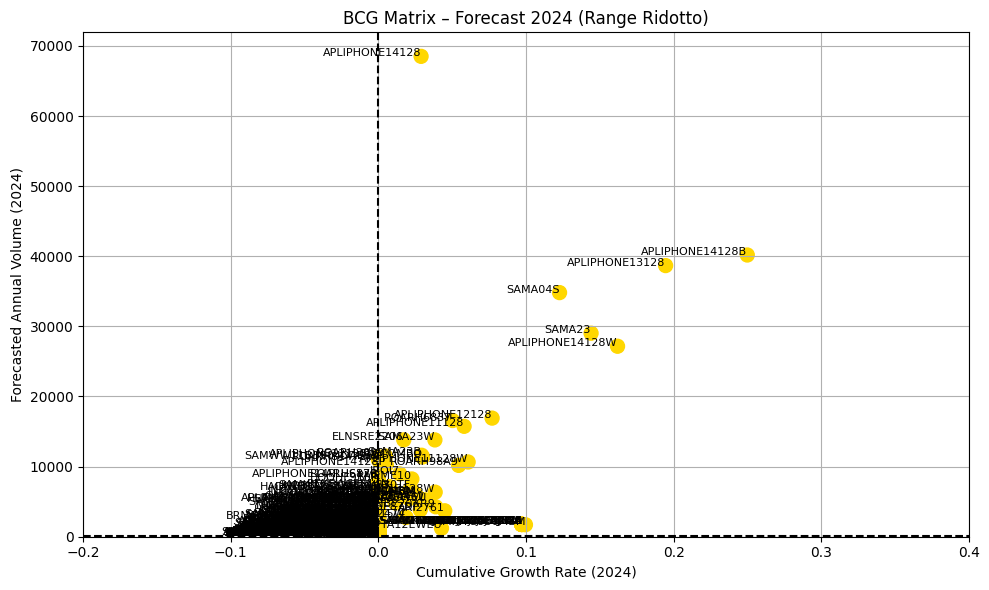

In [130]:
plt.figure(figsize=(10, 6))

plt.scatter(df_bcg['GROWTH_2024_CUMULATO'], df_bcg['QTA_FORECAST_2024_ANNUALE'],
            c=colors, s=100)

for i, row in df_bcg.iterrows():
    if -0.2 <= row['GROWTH_2024_CUMULATO'] <= 0.4:
        plt.text(row['GROWTH_2024_CUMULATO'], row['QTA_FORECAST_2024_ANNUALE'],
                 row['ART_COD'], fontsize=8, ha='right')

plt.axhline(median_volume, color='black', linestyle='--')
plt.axvline(median_growth, color='black', linestyle='--')

plt.xlim(-0.2, 0.4)  # Limita l’asse X per escludere outlier
plt.ylim(bottom=0)   # opzionale: parte da zero

plt.title('BCG Matrix – Forecast 2024 (Range Ridotto)')
plt.xlabel('Cumulative Growth Rate (2024)')
plt.ylabel('Forecasted Annual Volume (2024)')
plt.grid(True)
plt.tight_layout()
plt.show()
